Import of the differents libraries needed

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Declaration of the linear model

In [2]:
A = np.array([[0.9512, 0],[0.0476, 0.9512]])
B = np.array([0.0975, 0.0024])
C = np.array([0,1])
G = 1

Import of the data

In [3]:
with open('Data_linear_case/True_state_x1_linear_case.txt', "r") as f:
    f.readline()
    True_state_x1 = np.array(list(float(f.readline().split(" ")[0]) for i in range(1000)))        
with open('Data_linear_case/True_state_x2_linear_case.txt', "r") as f:
    f.readline()
    True_state_x2 = np.array(list(float(f.readline().split(" ")[0]) for i in range(1000)))   
with open('Data_linear_case/Input_linear_case.txt', "r") as f:
    f.readline()
    u = np.array(list(float(f.readline().split(" ")[0]) for i in range(1000)))  
with open('Data_linear_case/Measured_output_linear_case.txt', "r") as f:
    f.readline()
    y = np.array(list(float(f.readline().split(" ")[0]) for i in range(1000)))   

Defining noises w(k) and v(k)

In [4]:
mu_w = np.array([0,0])
Q = 0.001*np.array([[9.506,0.234],[0.234,9.512]])
w = np.random.multivariate_normal(mu_w, Q, 1000)
mu_v = 0
R = 0.0125
v = np.random.normal(mu_v, R, 1000)

Defining the vector for mu, mu_tilde, Pk, Pk_tilde and their initial value x_0 and P_0

In [5]:
mu_x_0 = np.array([5,5])
P_0 = np.array([[1,0],[0,1]])

muk_tilde = np.zeros((1000,2))
muk_tilde[0] = mu_x_0
Pk_tilde = np.zeros((1000,2,2))
Pk_tilde[0] = P_0

muk = np.zeros((1000,2))
muk[0] = mu_x_0
Pk = np.zeros((1000,2,2))
Pk[0] = P_0

Compute of the forecast step, x(k|k-1)

In [6]:
for k in range(1,1000):
    muk_tilde[k] = np.dot(A,muk_tilde[k-1])+B*u[k]
    Pk_tilde[k] = np.dot(A,np.matmul(Pk_tilde[k-1],A.transpose())) + Q

Compute of the update step x(k|k)

In [7]:
for k in range(1,1000):
    CPCTR = np.dot(C,np.dot(Pk_tilde[k],C.transpose()))+R #toujours un scalaire
    Kf = np.dot(Pk_tilde[k],C.transpose())/CPCTR
    muk[k] = muk_tilde[k] + Kf*(y[k]- np.dot(C,muk_tilde[k]))
    Pk[k] = np.dot(np.identity(2) - np.outer(Kf,C) , Pk_tilde[k])

Compute of the confidence interval

In [9]:
upper_x1 = np.array([(1.96 * Pk[w,0,0]**0.5)+muk[w,0] for w in range(1000)])
lower_x1 = np.array([-1.96 * Pk[w,0,0]**0.5+muk[w,0] for w in range(1000)])
upper_x2 = np.array([1.96 * Pk[w,1,1]**0.5+muk[w,1] for w in range(1000)])
lower_x2 = np.array([-1.96 * Pk[w,1,1]**0.5+muk[w,1] for w in range(1000)]) 

Compute of the RMSD function

In [10]:
def RMSD(x,y):
    n = len(x)
    v = np.power(x-y,2)
    rmsd = np.zeros(n)
    for i in range(n):
        rmsd[i] = np.sqrt(np.sum(v[:i+1,:]) / (i+1))
    return rmsd
        
rmsd = RMSD(np.array([True_state_x1, True_state_x2]).T,muk)

Vartiation of the true state depending on the input

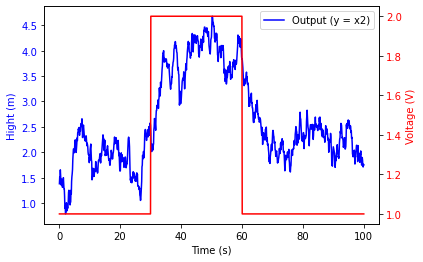

In [11]:
time = np.linspace(0.1,100,1000)
figure1 = plt.figure()
ax1 = figure1.add_subplot(1,1,1) #retourne un objet de type Axes
ax1.plot(time,y, label= "Output (y = x2)" , color='blue')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Hight (m)", color = 'blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(time,u,label='Motor input (u)', color = 'red')
ax2.set_ylabel("Voltage (V)", color = 'red')
ax2.tick_params(axis='y', labelcolor='red')
ax1.legend()
plt.show()
#figure1.savefig('Input_and_output.png')

Plot of the states, True values vs Filtered values with the confidence interval

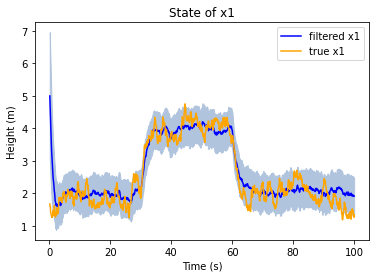

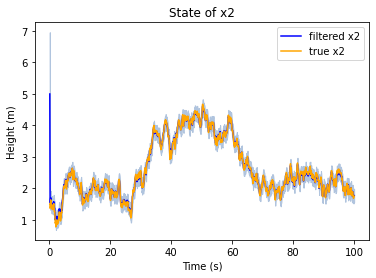

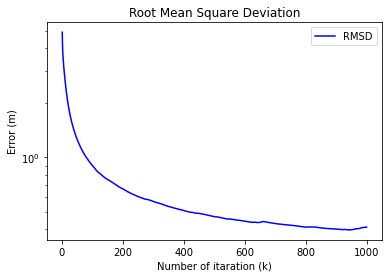

In [12]:
figure1 = plt.figure()
figure2 = plt.figure()
figure3 = plt.figure()
time = np.linspace(0.1,100,1000)
ax1 = figure1.add_subplot(1,1,1) #retourne un objet de type Axes
ax1.plot(time,muk[:,0], label= "filtered x1" , color='blue')
ax1.plot(time,True_state_x1, label= "true x1" , color='orange')
ax1.fill_between(time,upper_x1,lower_x1, color='lightsteelblue')
ax2 = figure2.add_subplot(1,1,1) #retourne un objet de type Axes
ax2.plot(time,muk[:,1], label= "filtered x2", color='blue' )
ax2.plot(time,True_state_x2, label= "true x2" , color='orange')
ax2.fill_between(time,upper_x2,lower_x2, color='lightsteelblue')
ax3 = figure3.add_subplot(1,1,1) #retourne un objet de type Axes
ax3.semilogy(time*10,rmsd, label= "RMSD" , color='blue')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_title("State of x1")
ax2.set_title("State of x2")
ax3.set_title("Root Mean Square Deviation")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax3.set_xlabel("Number of itaration (k)")
ax1.set_ylabel("Height (m)")
ax2.set_ylabel("Height (m)")
ax3.set_ylabel("Error (m)")
plt.show()
#figure1.savefig('Statex1.png')
#figure2.savefig('Statex2.png')
#figure3.savefig('RMSD.png')